# Comparing different importance sampling approaches for state space models

According to [@Agapiou2017Importance], at least for gaussian inverse problems the "difficulty" of an inverse problems
$$
y = Bx + \varepsilon
$$
with $x \sim \mathcal{N} (\mu, \Sigma)$ and $\varepsilon \sim \mathcal N(0, \Omega)$ may be judged by the whitened analouge

$$
y_{0} = Sx_{0} + \varepsilon_{0}
$$

where $x_0 \sim \mathcal{N}(0, I_{m}), \varepsilon_0 \sim \mathcal{N}(0, I_{p})$ and $S = \Omega ^{-\frac{1}{2}} B \Sigma^{\frac{1}{2}} \in \mathbf{R}^{p \times m}$ and we substracted the known mean. 

The difficulty is then ruled by the eigenvalues of $A = S^tS \in \mathbf{R}^{m \times m}$ or, more precisely by
$$
\begin{align*}
    \tau &= \operatorname{tr} \left( A \right) \\
    \operatorname{efd} &= \operatorname{tr} \left( (I + A)^{-1} A \right) = \operatorname{tr} \left(  (A^{-1} + I)^{-1} \right)
\end{align*}
$$
Both measure how "singular" the posterior is w.r.t. the prior (i.e., how far are the covariance/precision matrices of prior and posterior from one another), with big values corresponding to "harder" problems.

## Construction of $S$

In the finite dimensional case $A = S^tS$ is positive semi-definite and can be represented as $A = UDU^{t}$. 
Then
$$
\begin{align*}
    \tau &= \sum_{i = 1}^{m} \lambda_{i}\\
    \operatorname{efd} &= \sum_{i=1}^{m} \frac{\lambda_{i}}{1 + \lambda_{i}} \leq m
\end{align*}
$$

We consider the case where $m \gg p$ 
To control these two quantities we let $$S = I_{p \times m}D^{- \frac{1}{2}} U^{t}$$ for $D = \operatorname{diag} (d_1, \dots, d_m)$ where the entries $d_i^{2} \in \mathbf{R}$ follow some joint distribution (or are picked deterministically) and $U \in \operatorname{O} (m)$ uniformly.

The corresponding eigenvalues are then $\lambda_i = d_{i}^{2}\,\mathbf 1_{i \leq p}$.

In [1]:
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.distributions as tfd
import jax.random as jrn
import jax.scipy as jsp

def tau(S):
    A = S.T @ S
    eigvals = jnp.linalg.eigvalsh(A)
    return eigvals.sum()

def efd(S):
    A = S.T @ S
    eigvals = jnp.linalg.eigvalsh(A)
    return (eigvals/ (1. + eigvals)).sum()

def S(d, U, p):
    m, = d.shape
    return jnp.eye(p, m) @ jnp.diag(d) @ U.T

key = jrn.PRNGKey(179)

key, subkey = jrn.split(key)
m, p = (100, 10)
d = jrn.normal(subkey, (m,))

key, subkey = jrn.split(key)
U,_ = jsp.linalg.qr(jrn.normal(subkey, (m, m)))

S_test = S(d, U, p)

jnp.abs(d**2)[:p].sum(), tau(S_test), efd(S_test)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(Array(7.6771517, dtype=float32),
 Array(7.677152, dtype=float32),
 Array(3.9446895, dtype=float32))

We now consider some scenarios that [@Agapiou2017Importance] also considered. 

In [2]:
def S_spectral_jump(C, k, m, p, key):
    eps = 1. / (m - k)
    d = jnp.sqrt(jnp.concatenate((jnp.full(k, C), jnp.full(m - k, eps))))
    key, subkey = jrn.split(key)
    U, _ = jsp.linalg.qr(jrn.normal(subkey, (m, m)))
    return S(d, U, p)

def S_spectral_cascade(beta, gamma, m, p):
    d = jnp.sqrt(jnp.arange(1, m + 1)**(-beta) / gamma)
    key, subkey = jrn.split(key)
    U, _ = jsp.linalg.qr(jrn.normal(subkey, (m, m)))
    return S(d, U, p)


key, subkey = jrn.split(key)

S_test = S_spectral_jump(10, 5, 100, 10, key)
tau(S_test), efd(S_test)

(Array(50.05263, dtype=float32), Array(4.597537, dtype=float32))

## Simulation Study for NB inverse problems

In [3]:
from isssm.lcssm import nb_lcssm, simulate_lcssm
from isssm.mode_estimation import mode_estimation
from isssm.modified_efficient_importance_sampling import modified_efficient_importance_sampling
from isssm.importance_sampling import lcssm_importance_sampling, ess_pct

m, p = (20, 3)

def ess_pct_me_meis(m,p, params, N, key, n_iter=100):
    x0 = jnp.zeros(m)
    A = jnp.empty((0, m,m))
    Sigma = jnp.eye(m).reshape((1,m,m))
    key, subkey = jrn.split(key)
    C, k = params
    B = S_spectral_jump(C, k, m, p, subkey).reshape((1,p,m))
    r = 10.

    *_, xi_fun, dist = nb_lcssm(
        x0,
        A,
        Sigma,
        B,
        r
    )

    key, subkey = jrn.split(key)
    _, (y,) = simulate_lcssm((x0, A, Sigma, B, xi_fun, dist), 1, subkey)

    _, z, Omega = mode_estimation(y, x0, A, Sigma, B, xi_fun, dist, jnp.log(y + 1.), n_iter)

    key, sk_IS, sk_MEIS = jrn.split(key, 3)
    me_samples, me_log_weights = lcssm_importance_sampling(
        y, x0,  A, Sigma, B, xi_fun, dist, z, Omega, N , sk_IS
    )

    z_meis, Omega_meis = modified_efficient_importance_sampling(
        y, x0,  A, Sigma, B, xi_fun, dist, z, Omega, n_iter, N , sk_MEIS
    )

    meis_samples, meis_log_weights = lcssm_importance_sampling(
        y, x0,  A, Sigma, B, xi_fun, dist, z_meis, Omega_meis, N , sk_IS
    )
    
    return ess_pct(me_log_weights), ess_pct(meis_log_weights)
    

In [9]:
import pandas as pd
from jax import vmap
key = jrn.PRNGKey(97520)
key, subkey = jrn.split(key)

simulation_parameters = pd.DataFrame({
    "m": [20, 30, 40],#, 50, 60, 70, 80, 90, 100],
    "p": 10
})

# apply ess_pct_me_meis to each row of parameters
S_params = (10, 8)

repetitions = 10

# make sure columns are numeric
def multiple_simulation(m, p, key):
    keys = jrn.split(key, repetitions)
    ess_me, ess_meis = vmap(ess_pct_me_meis, (None, None, None, None, 0))(
        m, p, S_params, 1000, keys
    )

    return pd.DataFrame({
        "m": m,
        "p": p,
        "me": [*ess_me],
        "meis": [*ess_meis]
    })

effective_sample_sizes = pd.concat(
    [*simulation_parameters.apply(
    lambda row: multiple_simulation(row.m, row.p, subkey),
    axis=1
)])

In [8]:
pd.concat([*effective_sample_sizes])

,m,p,me,meis
0,20,10,34.22021,66.51941
1,20,10,12.378574,52.70287
0,30,10,19.025225,53.706318
1,30,10,34.738533,67.97855
0,40,10,20.578892,61.98459
1,40,10,4.2862835,18.327566


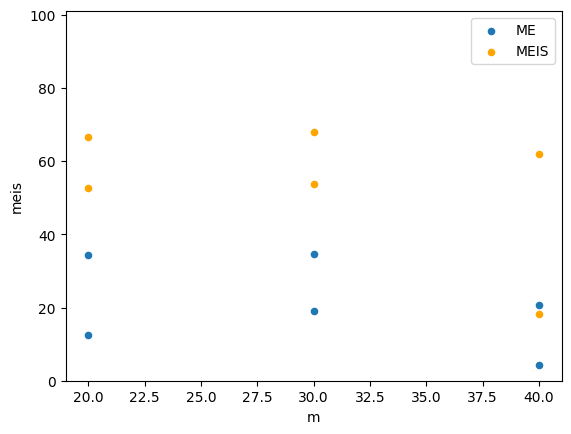

In [15]:
import matplotlib.pyplot as plt
ax = effective_sample_sizes.plot(x="m", y="me", kind="scatter", label="ME")
effective_sample_sizes.plot(x="m", y="meis", kind="scatter", ax=ax,color="orange", label="MEIS")
ax.set_ylim(0,101)
plt.legend()
plt.show()